# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
holding

,Price in USDT,Weights in %
Total,1652.651223,1.000000e+00
BTCUSDT,699.555633,4.232930e-01
JASMYUSDT,263.149990,1.592290e-01
OMUSDT,194.123071,1.174616e-01
SOLUSDT,192.533336,1.164997e-01
ETHUSDT,162.649903,9.841756e-02
BBUSDT,94.171928,5.698234e-02
BNBUSDT,46.411003,2.808276e-02
TRXUSDT,0.056356,3.410041e-05
PEPEUSDT,0.000002,1.051402e-09


In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

1.0

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

### Positions

In [11]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [12]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today()-datetime.timedelta(1),
                                        startdate=datetime.datetime(2024,5,5))
positions=positions.iloc[:-1]

2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
2024-08-03 00:00:00
LDUMAUSDT not retrieved
LDUMAUSDT


In [13]:
positions=positions.sort_index()

In [14]:
positions.index=pd.to_datetime(positions.index)

In [15]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [16]:
positions.to_excel('Positions.xlsx')

In [17]:
positions['Total']=positions.sum(axis=1)
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total']).fillna(0)

In [18]:
binance_data=Binance.get_price(positions.columns,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()

binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [19]:
historical_ptf=pd.DataFrame()

In [20]:
for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

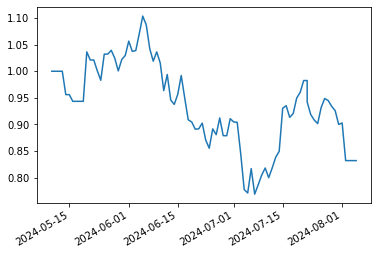

In [21]:
historical_ptf.dropna(axis = 0, how = 'all', inplace = True)
(1+historical_ptf['Historical Portfolio']).cumprod().plot()

### Ex ante data

In [22]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

In [23]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use)
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [24]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT', 'ENSUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT',
       'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'NEXOUSDT',
       'OMUSDT', 'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT',
       'SANDUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT',
       'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'TUSDUSDT', 'UNIUSDT', 'USDCUSDT',
       'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT',
       'XTZUSDT'],
      dtype='object')

In [25]:
limit=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [26]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
OMUSDT,0.476764
BTCUSDT,0.400000
PEPEUSDT,0.070749
JASMYUSDT,0.052487


In [27]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [28]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
OMUSDT,0.6
BTCUSDT,0.4


## Real Portfolio vs Optimal

In [29]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,699.555633,4.232930e-01,0.4,0.023293
JASMYUSDT,263.149990,1.592290e-01,0.0,0.000000
OMUSDT,194.123071,1.174616e-01,0.6,-0.482538
SOLUSDT,192.533336,1.164997e-01,0.0,0.000000
ETHUSDT,162.649903,9.841756e-02,0.0,0.000000
BBUSDT,94.171928,5.698234e-02,0.0,0.000000
BNBUSDT,46.411003,2.808276e-02,0.0,0.000000
TRXUSDT,0.056356,3.410041e-05,0.0,0.000000
PEPEUSDT,0.000002,1.051402e-09,0.0,0.000000


In [30]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,699.555633,4.232930e-01,0.400000,0.023293
JASMYUSDT,263.149990,1.592290e-01,0.052487,0.106742
OMUSDT,194.123071,1.174616e-01,0.476764,-0.359302
SOLUSDT,192.533336,1.164997e-01,0.000000,0.000000
ETHUSDT,162.649903,9.841756e-02,0.000000,0.000000
BBUSDT,94.171928,5.698234e-02,0.000000,0.000000
BNBUSDT,46.411003,2.808276e-02,0.000000,0.000000
TRXUSDT,0.056356,3.410041e-05,0.000000,0.000000
PEPEUSDT,0.000002,1.051402e-09,0.070749,-0.070749


## Risk Reward Analysis

In [31]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [32]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

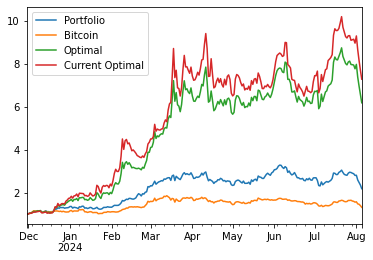

In [33]:
(1+portfolio_perf).cumprod().plot()

In [34]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

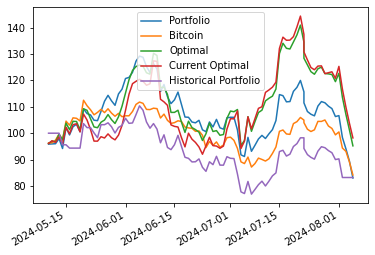

In [35]:
((1+current_perf).cumprod()*100).plot()

In [36]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.772282
dtype: float64

In [37]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.557412
dtype: float64

In [38]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.524774
Bitcoin            0.440347
Optimal            0.773790
Current Optimal    0.879342
dtype: float64

In [39]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.3203602980000657

In [40]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.016367,0.059273,0.142076,0.051816,0.090259
JASMYUSDT,0.008437,0.013364,0.029148,0.006028,0.023121
OMUSDT,0.958983,0.905050,0.773785,0.682102,0.091683
PEPEUSDT,0.016213,0.022313,0.054992,0.015403,0.039589


In [41]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.426628,0.414026,0.258647,0.083934,0.174713
JASMYUSDT,0.085376,0.170713,0.263438,0.097466,0.165972
OMUSDT,-0.124715,0.159813,0.135208,0.037914,0.097294
SOLUSDT,0.148480,0.113817,0.125058,0.022023,0.103035
ETHUSDT,0.169986,0.087060,0.080989,0.010217,0.070773
BBUSDT,0.241078,0.028819,0.115883,0.028941,0.086941
BNBUSDT,0.053168,0.025752,0.020777,0.000656,0.020121


## Value At Risk

### Historical

In [42]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.06453877362839124, -0.09080151948351085)

In [43]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.05304357451466562, -0.07297897901599633)

In [44]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [45]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.017296
JASMYUSDT   -0.012250
OMUSDT      -0.005229
SOLUSDT     -0.009876
ETHUSDT     -0.004485
BBUSDT      -0.002453
BNBUSDT     -0.002063
TRXUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.053654
Name: 2024-07-07 00:00:00, dtype: float64

In [46]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.020373
JASMYUSDT   -0.015925
OMUSDT      -0.012378
SOLUSDT     -0.009228
ETHUSDT     -0.007406
BBUSDT      -0.005712
BNBUSDT     -0.001956
TRXUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.072979
dtype: float64

### Parametric

In [47]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.08017703693976039, -0.10276479363377984)

In [48]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.057756773718818655, -0.07402821504400005)

### Multivariate

In [49]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07305695878486247, -0.09302524449327854)

In [50]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05861309632862106, -0.07355608805571566)

In [51]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

BTCUSDT     -0.015076
JASMYUSDT   -0.015429
OMUSDT      -0.006375
SOLUSDT     -0.007636
ETHUSDT     -0.004512
BBUSDT      -0.008356
BNBUSDT     -0.001368
Portfolio   -0.058753
dtype: float64

### Copulas

In [52]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07257536725507487, -0.09322815059136629)

In [53]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0584382501958394, -0.07304567948614821)

In [54]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.015288
JASMYUSDT   -0.014465
OMUSDT      -0.007759
SOLUSDT     -0.007091
ETHUSDT     -0.005087
BBUSDT      -0.007590
BNBUSDT     -0.001331
Portfolio   -0.058611
dtype: float64

In [55]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07129343670334799, -0.09187584991591745)

In [56]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.059085464782165587, -0.07547622163271372)

In [57]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.015625
JASMYUSDT   -0.015823
OMUSDT      -0.007036
SOLUSDT     -0.007717
ETHUSDT     -0.005202
BBUSDT      -0.007046
BNBUSDT     -0.001332
Portfolio   -0.059782
dtype: float64

In [58]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.1400554132581235, -0.20238566935917698)

In [59]:
gumbel_copula=current_risk.gumbel_copula()
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06554021901661598, -0.08644237095790001)

In [60]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.024209
JASMYUSDT   -0.020187
OMUSDT      -0.006245
SOLUSDT     -0.005306
ETHUSDT     -0.002428
BBUSDT      -0.006701
BNBUSDT     -0.000273
Portfolio   -0.065348
dtype: float64

### Monte Carlo

In [61]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [62]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.08212023199142203, -0.10280549699162035)

In [63]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05905297509202683, -0.07346610615626845)

In [64]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.015053
JASMYUSDT   -0.015073
OMUSDT      -0.008536
SOLUSDT     -0.007662
ETHUSDT     -0.004784
BBUSDT      -0.006519
BNBUSDT     -0.001252
Portfolio   -0.058879
dtype: float64

### VaR Violation

In [65]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.059753,-0.109470,-0.094401,-0.025769
2024-01-15,-0.059753,-0.109464,-0.095234,0.014602
2024-01-16,-0.059753,-0.110313,-0.089280,0.060822
2024-01-17,-0.059753,-0.112573,-0.097976,-0.035791
2024-01-18,-0.059753,-0.114763,-0.100524,-0.037282
...,...,...,...,...
2024-08-01,-0.104239,-0.097584,-0.092698,0.026417
2024-08-02,-0.110666,-0.103437,-0.100380,-0.074167
2024-08-03,-0.069124,-0.090710,-0.083757,-0.056776
2024-08-04,-0.069124,-0.094069,-0.091941,-0.054826


In [66]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.036911,-0.090073,-0.078975,-0.018287
2024-05-29,-0.027664,-0.086257,-0.073075,-0.015103
2024-05-30,-0.027664,-0.074941,-0.066109,0.039050
2024-05-31,-0.026440,-0.071362,-0.059729,0.015522
2024-06-01,-0.026440,-0.071782,-0.059046,0.034769
...,...,...,...,...
2024-08-01,-0.035115,-0.050448,-0.050292,0.003308
2024-08-02,-0.071928,-0.068496,-0.076127,-0.077770
2024-08-03,-0.072956,-0.066727,-0.077585,-0.043386
2024-08-04,-0.073824,-0.068609,-0.083235,-0.049587


<AxesSubplot:>

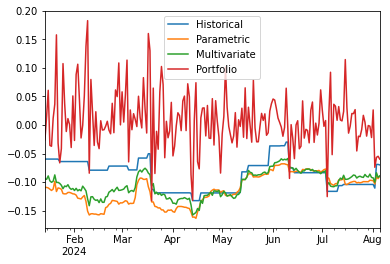

In [67]:
var_data.plot()

<AxesSubplot:>

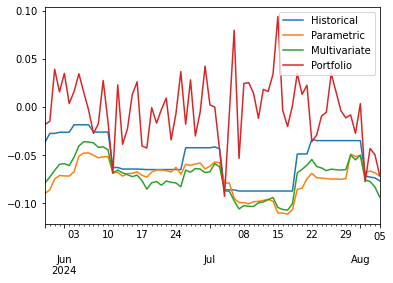

In [68]:
current_var_data.plot()

In [69]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.02439,0.009756,0.014634
Kupiec Stat,3.461875,10.308131,7.394617
P-value,0.062799,0.001324,0.006542


In [70]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.085714,0.042857,0.028571
Kupiec Stat,1.563143,0.078846,0.79512
P-value,0.211206,0.778868,0.372556


## Principal Component Analysis

In [71]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77144704, 0.07254651, 0.06023784, 0.05332466, 0.04244396])

In [72]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.62694751, 0.16644226, 0.09497629, 0.07666795, 0.03496599])

In [73]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))

<AxesSubplot:>

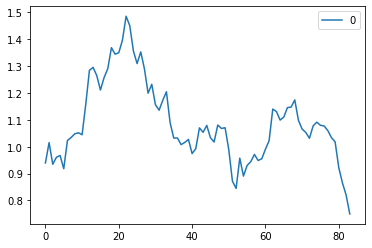

In [74]:
x=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)))
x=x.dropna()
(1+x).cumprod().plot()

<AxesSubplot:>

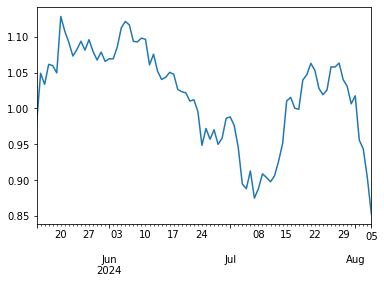

In [75]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()